In [1]:
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
from utils.network import VarNet2
from VN_SPIRIT.utils.dataset import *
import torch
from script.train_knee3d import *
from utils.cg_spirit_gpu import *
from scipy.linalg import null_space
import fastmri.data.transforms as T
from functools import partial

%matplotlib inline

In [2]:
net = torch.load('exp/E2EVN_knee2d.pt')

# SPIRIT refinement

In [21]:
class Data2D(Dataset):
    def __init__(self, root, dset_type='knee2d'):
        super().__init__()
        self.examples = []
        Files = list(pathlib.Path(root).glob('*.h5'))
        for fname in sorted(Files):
            data = h5py.File(fname, 'r')
            ksp = data['kspace']

            num_slices = ksp.shape[0]
            self.examples += [(fname, slice_num)
                              for slice_num in range(num_slices)]
            
        self.mask_func = subsample.EquispacedMaskFunc(
                        center_fractions=[0.08],
                        accelerations=[4]
                    )
        self.dset_type = dset_type

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, idx):
        fname, sl = self.examples[idx]
        with h5py.File(fname, 'r') as hr:
            kspace, sens = hr['kspace'][sl], hr['sens'][sl]
            if self.dset_type == 'brain2d':
                kspace = kspace[:,::2]
            et_root = etree.fromstring(hr["ismrmrd_header"][()])

            enc = ["encoding", "encodedSpace", "matrixSize"]
            enc_size = (
                int(et_query(et_root, enc + ["x"])),
                int(et_query(et_root, enc + ["y"])),
                int(et_query(et_root, enc + ["z"])),
            )
            rec = ["encoding", "reconSpace", "matrixSize"]
            recon_size = (
                int(et_query(et_root, rec + ["x"])),
                int(et_query(et_root, rec + ["y"])),
                int(et_query(et_root, rec + ["z"])),
            )

            lims = ["encoding", "encodingLimits", "kspace_encoding_step_1"]
            enc_limits_center = int(et_query(et_root, lims + ["center"]))
            enc_limits_max = int(et_query(et_root, lims + ["maximum"])) + 1

            padding_left = enc_size[1] // 2 - enc_limits_center
            padding_right = padding_left + enc_limits_max
            attrs = dict(hr.attrs)
            max_value = attrs['max']
            
        kspace = kspace / max_value
        
        im_coil = sp.ifft(kspace, axes=[1, 2])
        im_comb = np.sum(im_coil * np.conj(sens), axis=0)
        
        mask = self.mask_func(list(im_comb.shape) + [1])[...,0] # weird trick
        mask[:,:padding_left] = 0
        mask[:,padding_right:] = 0
                              
        mask = np.expand_dims(mask, axis=0)
        masked_kspace = kspace * mask
        mask = np.expand_dims(mask, axis=-1)
        
        masked_kspace = transforms.to_tensor(masked_kspace)
        mask = transforms.to_tensor(mask)
        sens = transforms.to_tensor(sens)
        im_comb = np.expand_dims(im_comb, axis=0)
        im_comb = transforms.to_tensor(im_comb)
                        
        return masked_kspace, mask.byte(), sens, im_comb


In [22]:
testset = Data2D('data/div_knee2d/Test', dset_type='knee2d')

In [23]:
ksp, mask, sens, labels = testset[80]
ksp = ksp.unsqueeze(0).cuda()
mask = mask.unsqueeze(0).cuda()
sens = sens.unsqueeze(0).cuda()

with torch.no_grad():
    out, ksp_out = net(ksp, mask, sens)

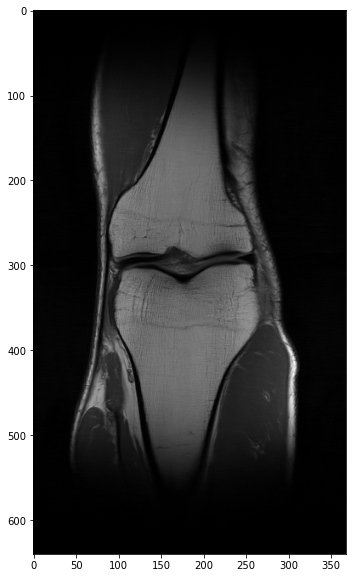

In [24]:
out_np = from_pytorch(out.cpu().detach(), iscomplex=True).squeeze()
plt.figure(figsize=(10,10))
plt.imshow(np.abs(out_np), cmap='gray')

In [25]:
im_coil = fastmri.complex_abs(fastmri.ifft2c(ksp))

im_coil.shape

torch.Size([1, 15, 640, 368])

In [26]:
out.shape

torch.Size([1, 1, 640, 368, 2])

In [27]:
with torch.no_grad():
    ksp_us_vcc = torch_VCC(ksp)
    ksp_out_vcc = torch_VCC(ksp_out)
print(ksp_us_vcc.shape, ksp_out_vcc.shape)

torch.Size([1, 30, 640, 368, 2]) torch.Size([1, 30, 640, 368, 2])


In [28]:
ksp_us_vcc_np = from_pytorch(ksp_us_vcc.cpu().detach(), iscomplex=True)[0]
mask = np.abs(ksp_us_vcc_np) > 0
print(mask.shape)

(30, 640, 368)


# Preparing calibration

In [29]:
# Preparing calibration line 
center_fractions = 0.06

ksp_vn_np = np.moveaxis(from_pytorch(ksp_us_vcc.detach().cpu(),iscomplex=True)[0],0,-1)
print(ksp_vn_np.shape)

nro, npe, ncoil = ksp_vn_np.shape
kernel_size = [5,5]
kx, ky = kernel_size[:]
kx2, ky2 = int(kx/2), int(ky/2)

calib = sp.resize(ksp_vn_np,[round(npe*center_fractions),round(npe*center_fractions),ncoil]) # This is the calibration region

print(mask.shape, calib.shape)

(640, 368, 30)
(30, 640, 368) (22, 22, 30)


In [30]:
# Preparing calibration kernel
algorithm = 'pruno'

if algorithm == 'spirit':
    GOP = spirit_calibrate(calib, kernel_size, lamda=0.01)
    GOP = GOP.copy()
    for n in range(ncoil):
        GOP[n,n,2,2] = -1
    print('SPIRIT kernel: {}'.format(GOP.shape))
else:
    C = view_as_windows(
        calib, (kx, ky, ncoil)).reshape((-1, kx*ky*ncoil))
    n = null_space(C, rcond=1e-3)
    print(n.shape)
    n = n[:,-200:] # choosing only 200
    n = np.reshape(n, (kx, ky, ncoil, n.shape[-1]))
    GOP = np.transpose(n[::-1,::-1],[3,2,0,1])
    print('PRUNO kernel: {}'.format(GOP.shape))

(750, 554)
PRUNO kernel: (200, 30, 5, 5)


In [31]:
GOP_t = T.to_tensor(GOP)
mask_t = T.to_tensor(mask)
mask_t = mask_t.unsqueeze(0).unsqueeze(-1)

# To GPU
GOP_t = GOP_t.type(torch.FloatTensor).to('cuda:0')
mask_t = mask_t.type(torch.FloatTensor).to('cuda:0')

print(GOP_t.shape, mask_t.shape)



torch.Size([200, 30, 5, 5, 2]) torch.Size([1, 30, 640, 368, 1])


In [32]:
%%time

l2lam = 0.05
# This is solving Ax = b by conjugate gradient algorithm
with torch.no_grad():
    ATA = partial(AHA, gop=GOP_t, m=mask_t)
    b = AHb(ksp_us_vcc, mask_t, GOP_t) + l2lam * ksp_out_vcc
    res = conjgrad(30, ATA, b, ksp_us_vcc, l2lam=l2lam, device='cuda:0')

Initial Error: 0.9639979004859924
[Iter:1/30] Error:0.2597332000732422
[Iter:2/30] Error:0.1464533656835556
[Iter:3/30] Error:0.10140259563922882
[Iter:4/30] Error:0.06989852339029312
[Iter:5/30] Error:0.04644657298922539
[Iter:6/30] Error:0.031080245971679688
[Iter:7/30] Error:0.02249065227806568
[Iter:8/30] Error:0.017118897289037704
[Iter:9/30] Error:0.012600015848875046
[Iter:10/30] Error:0.009042843244969845
[Iter:11/30] Error:0.006711561232805252
[Iter:12/30] Error:0.005464096087962389
[Iter:13/30] Error:0.00482086231932044
[Iter:14/30] Error:0.004269310273230076
[Iter:15/30] Error:0.003562812227755785
[Iter:16/30] Error:0.002761718351393938
[Iter:17/30] Error:0.0021292846649885178
[Iter:18/30] Error:0.0016513192094862461
[Iter:19/30] Error:0.0012827289756387472
[Iter:20/30] Error:0.0009714899933896959
[Iter:21/30] Error:0.0007260760758072138
[Iter:22/30] Error:0.0005396736087277532
[Iter:23/30] Error:0.00040158434421755373
[Iter:24/30] Error:0.0003046388446819037
[Iter:25/30] Er

In [33]:
# Plotting resulting coil combined image
res_vn = from_pytorch(out.cpu().detach(), iscomplex=True)[0]
res_np = from_pytorch(res.detach().cpu(),iscomplex=True)[0][:res.shape[1]//2]
sens_np = from_pytorch(sens.detach().cpu(), iscomplex=True)[0]

im_coil = sp.ifft(res_np, axes=(1,2))
res_vn_spirit = np.sum(im_coil * np.conj(sens_np), axis=0)

In [34]:
res_vn_spirit_vis = sp.resize(np.abs(res_vn_spirit.squeeze()),[240,240])
res_vn_vis = sp.resize(np.abs(res_vn.squeeze()),[240,240])
labels_vis = sp.resize(np.abs(from_pytorch(labels.cpu(), iscomplex=True)[0]),[240,240])

In [35]:
out_cat = np.concatenate((res_vn_vis, res_vn_spirit_vis, labels_vis), axis=1)
error_cat = np.concatenate((labels_vis,labels_vis,labels_vis),axis=1)
error_cat = np.abs(out_cat-error_cat) * 5
out_cat = np.concatenate((out_cat,error_cat),axis=0)

(-0.5, 719.5, 479.5, -0.5)

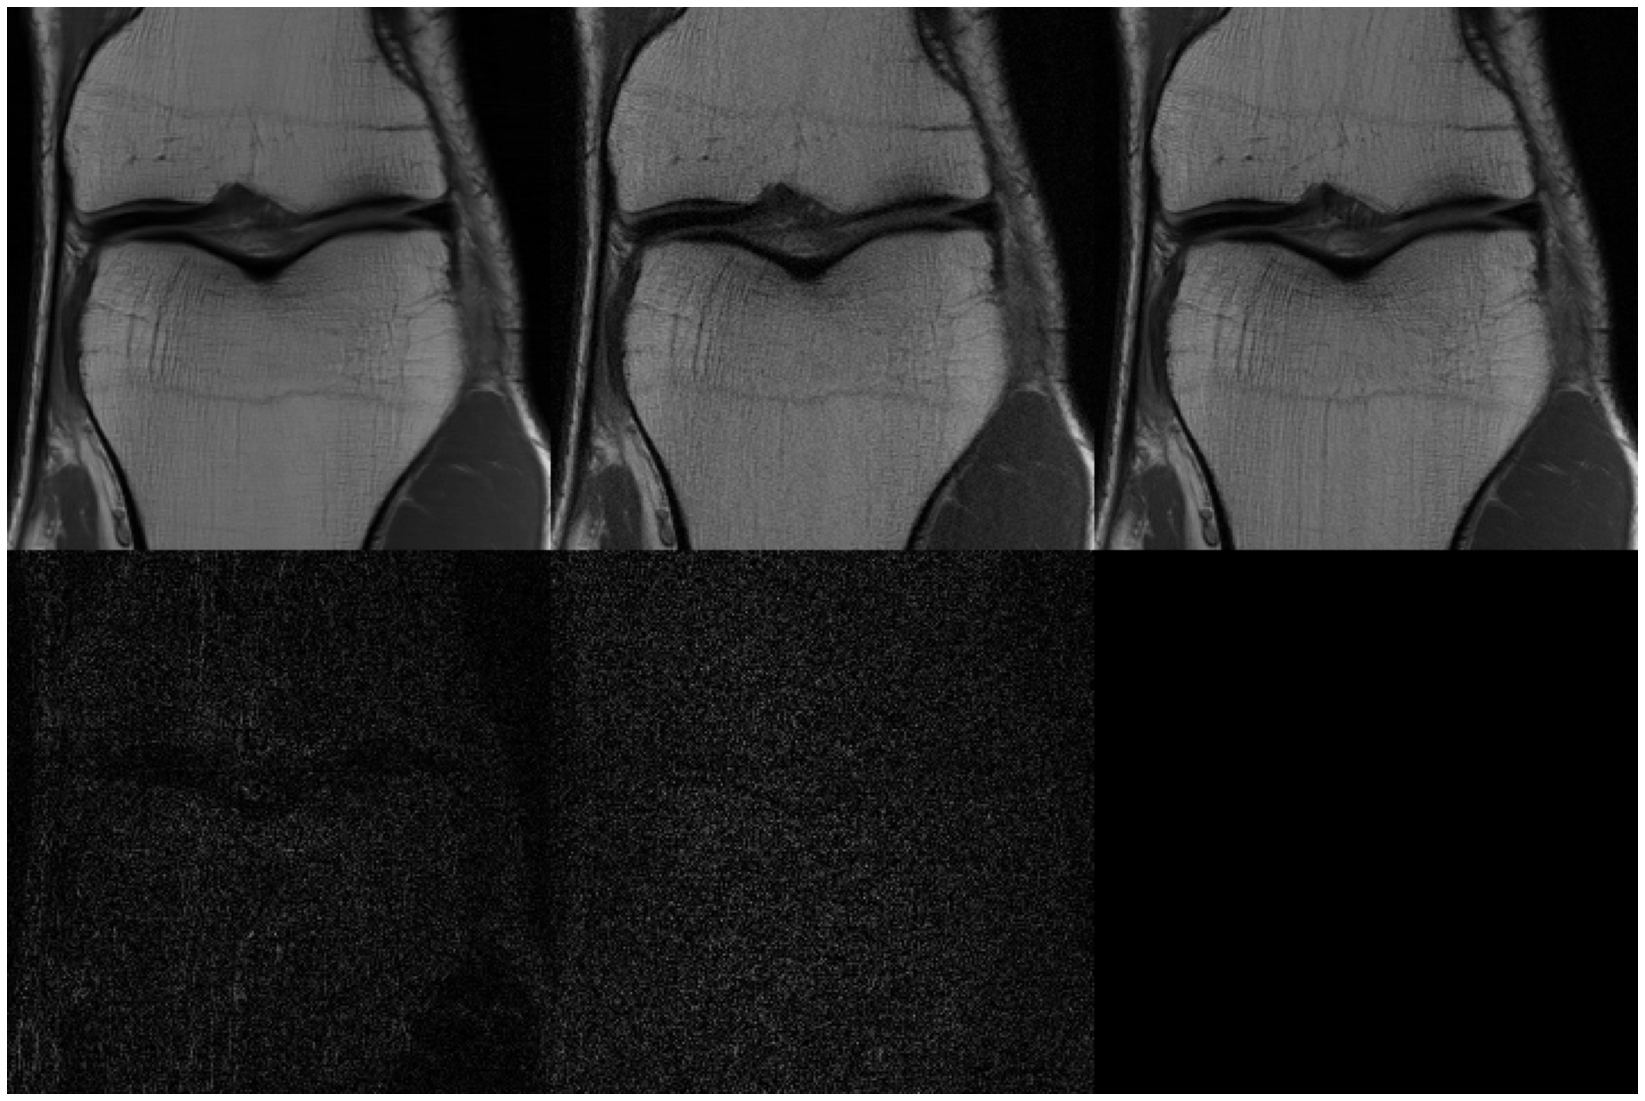

In [36]:
plt.figure(figsize=(30,20))
plt.imshow(out_cat,cmap='gray',vmax=0.8)
plt.axis('off')


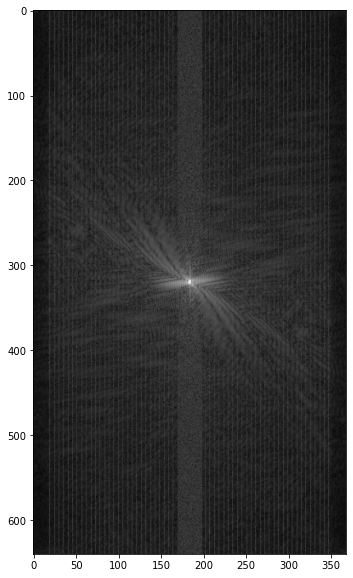

In [37]:
ksp_out_np = from_pytorch(ksp_out[0].cpu().detach(),iscomplex=True)
plt.figure(figsize=(10,10))
plt.imshow(np.abs(ksp_out_np[0])**0.2, cmap='gray')

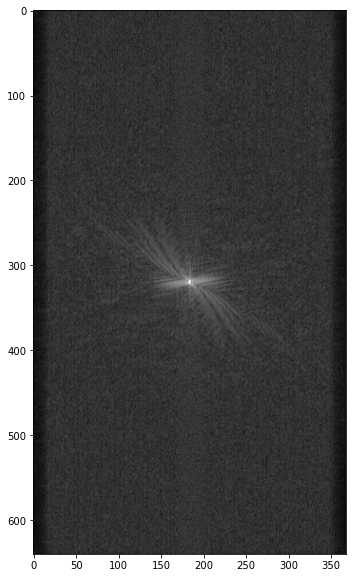

In [38]:
plt.figure(figsize=(10,10))
plt.imshow(np.abs(res_np[0])**0.2, cmap='gray')